In [10]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt


def find_project_root(start: Path, marker_dir: str = "src") -> Path:
    for p in [start, *start.parents]:
        if (p / marker_dir).is_dir():
            return p
    return start  # fallback: current dir

project_root = find_project_root(Path.cwd())


src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

import imagenet16h.online_helpers as oh
from imagenet16h.online_helpers import RunConfig, Phase
from imagenet16h.online_helpers import *


oh.DATA_PATH = project_root / "data"
oh.MODELS_DIR = oh.DATA_PATH / "models"
oh.USERS_DIR = oh.DATA_PATH / "users"
oh.TRUE_LABELS_CSV = oh.DATA_PATH / "imagenet16H.csv"


### Noise Shift

[calibration] Warning: no matching test phase found to receive use_indices.
[calib] noise=80  |pool|=1200  |calib|=600  |test|=600  |inH|=586  |notH|=14


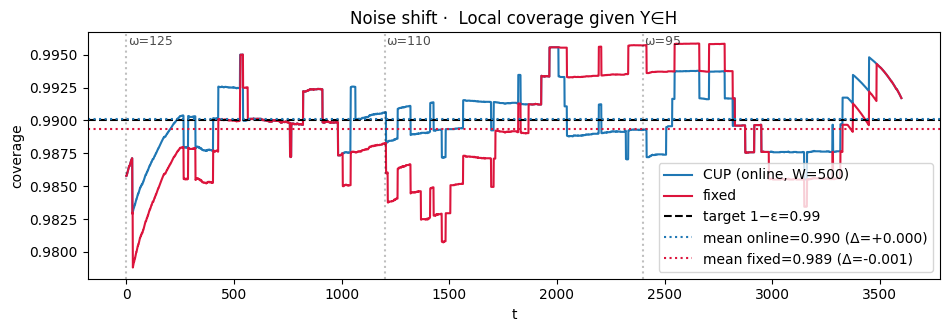

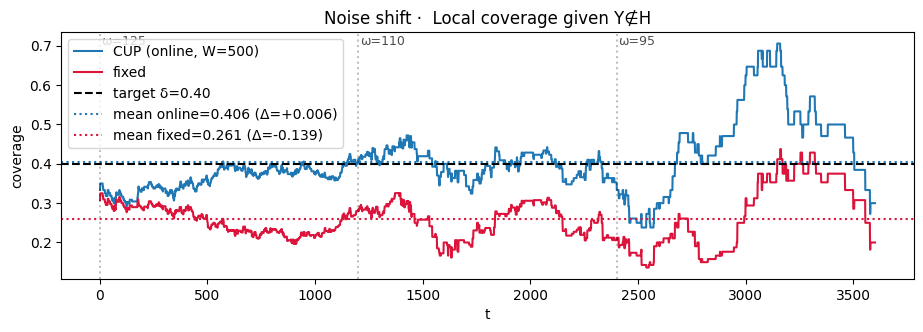

[Y∈H] mean online = 0.9901 (Δ=+0.0001), fixed = 0.9894 (Δ=-0.0006), target = 0.9900
[Y∉H] mean online = 0.4059 (Δ=+0.0059), fixed = 0.2607 (Δ=-0.1393), target = 0.4000


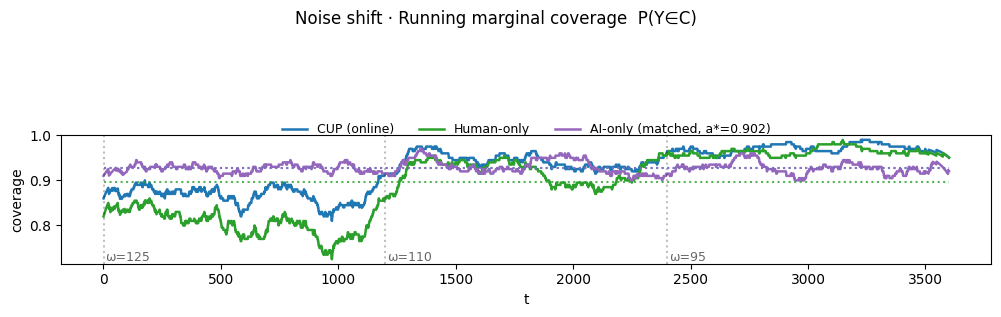

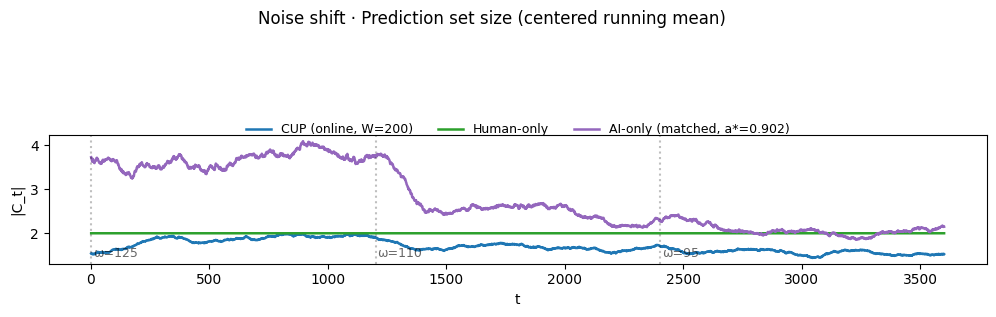

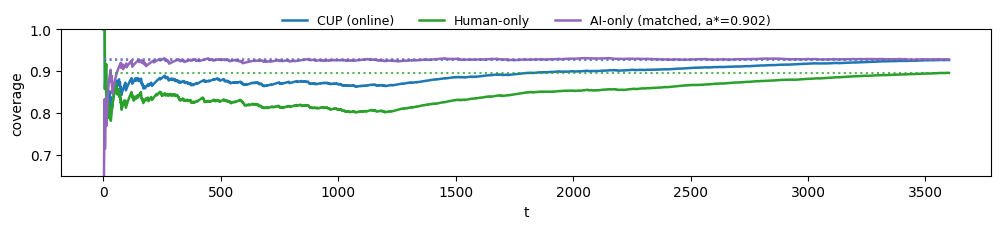

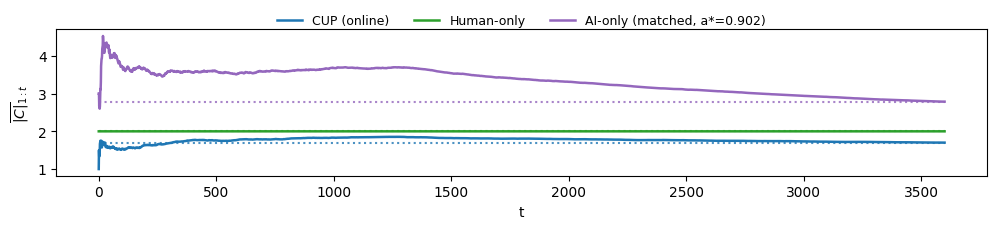

In [3]:
# =======================
#  NOISE SHIFT
# =======================

# Test phases: noise level changes, human policy fixed.
noise_phases = [
    Phase(name="ω=125", steps=5000, noise_level=125),
    Phase(name="ω=110", steps=5000, noise_level=110),
    Phase(name="ω=95",  steps=5000, noise_level=95),
]

cfg_noise = RunConfig(
    mode="noise",
    model_name="alexnet",
    eps=0.01,
    delta=0.40,
    steps_report=250,
    noise_phases=noise_phases,
    fixed_policy={"mode": "topk", "k": 2},
    seed=1337,
    eta=0.005,
    eta_a=0.005,
    eta_b=0.005,
    normalize_levels=True,
)

# Calibrate on a chosen noise level (e.g., ω=80) and compare fixed vs adaptive.
res_noise = compare_online_levels_with_calibration(
    cfg_test=cfg_noise,
    calib_noise_level=80,
    calib_steps=2000,
    W=500,
)

events_n      = res_noise["events"]
phase_bounds_n = res_noise["phase_bounds"]
phase_names_n  = res_noise["phase_names"]
q_inH0_n       = res_noise["q_inH0"]
q_notH0_n      = res_noise["q_notH0"]


_ = plot_marginal_coverage_hai_vs_baselines(
    cfg_noise, adaptive=res_noise["adaptive"], W=200, ai_calib_noise=None
)
_ = plot_set_sizes_hai_vs_baselines(
    cfg_noise, q_inH0=q_inH0_n, q_notH0=q_notH0_n, W=200, ai_calib_noise=None
)

_ = plot_cum_marginal_coverage_hai_vs_baselines(
    cfg_noise, adaptive=res_noise["adaptive"], events=events_n
)
_ = plot_cum_set_sizes_hai_vs_baselines(
    cfg_noise, q_inH0=q_inH0_n, q_notH0=q_notH0_n, events=events_n
)


[calib/human] ω=125 |pool|=1200 |calib|=600 |test|=600 |inH|=445 |notH|=155


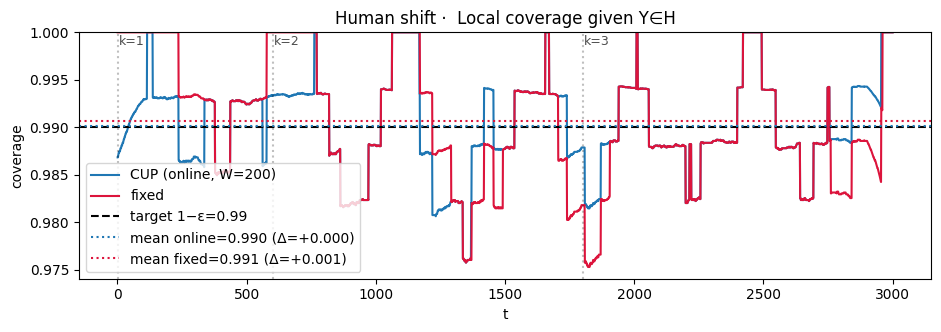

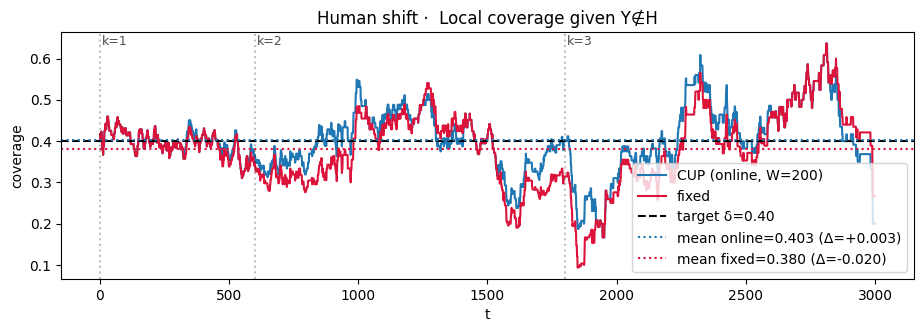

[Y∈H] mean online = 0.9902 (Δ=+0.0002), fixed = 0.9906 (Δ=+0.0006), target = 0.9900
[Y∉H] mean online = 0.4028 (Δ=+0.0028), fixed = 0.3803 (Δ=-0.0197), target = 0.4000


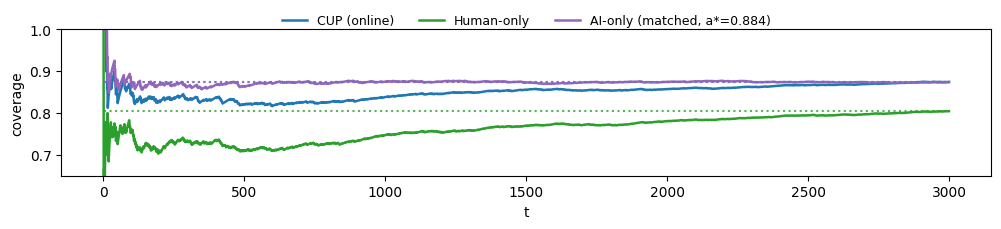

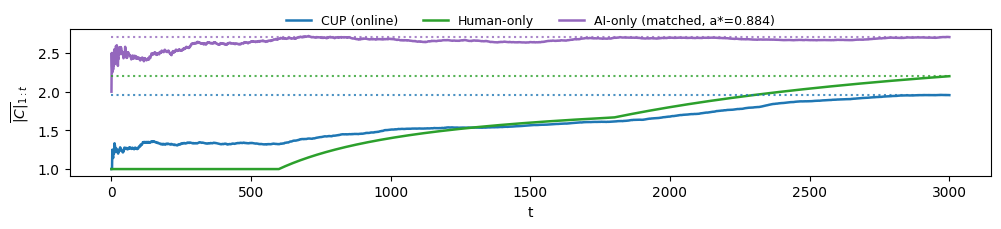

In [9]:
# =======================
# HUMAN SHIFT
# =======================

# Phases: same noise, different human policies
human_phases = [
    Phase(name="k=1", steps=None, human_policy={"mode": "topk", "k": 1}),
    Phase(name="k=2", steps=None, human_policy={"mode": "topk", "k": 2}),
    Phase(name="k=3", steps=None, human_policy={"mode": "topk", "k": 3}),
]

cfg_human = RunConfig(
    mode="human",
    model_name="alexnet",
    eps=0.01,
    delta=0.40,
    steps_report=500,
    human_phases=human_phases,
    fixed_noise_level=125,               # fixed noise
    seed=1337,
    fixed_policy={"mode": "topk", "k": 1},  # baseline human policy
    eta=0.005,
    eta_a=0.005,
    eta_b=0.005,
    normalize_levels=True,
)

res_human = compare_online_levels_with_calibration_human(
    cfg_human=cfg_human,
    calib_policy={"mode": "topk", "k": 1},
    calib_steps=2000,   # ignored; we always half-split the full pool
    W=200,
)

q_inH0_h  = res_human["q_inH0"]
q_notH0_h = res_human["q_notH0"]
events_h  = res_human["events"]


# Plotting running coverage and set size
_ = plot_cum_marginal_coverage_hai_vs_baselines(
    cfg_human, adaptive=res_human["adaptive"], events=events_h
)
_ = plot_cum_set_sizes_hai_vs_baselines(
    cfg_human, q_inH0=q_inH0_h, q_notH0=q_notH0_h, events=events_h
)


[calib/class] ω=125 subset=['car', 'cat', 'dog', 'truck'] |pool|=300 |calib|=150 |test|=150 |inH|=125 |notH|=25
[calib/class] Warning: no matching test phase found to receive use_indices.


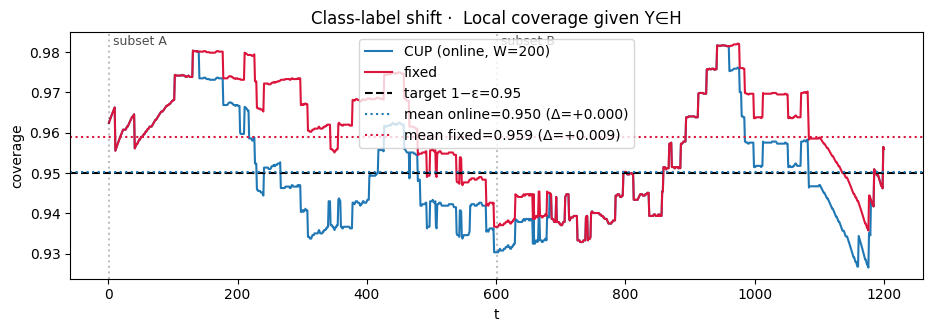

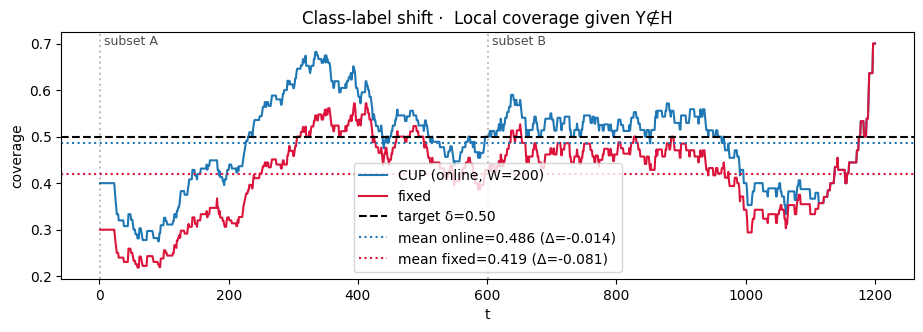

[Y∈H] mean online = 0.9504 (Δ=+0.0004), fixed = 0.9590 (Δ=+0.0090), target = 0.9500
[Y∉H] mean online = 0.4865 (Δ=-0.0135), fixed = 0.4190 (Δ=-0.0810), target = 0.5000


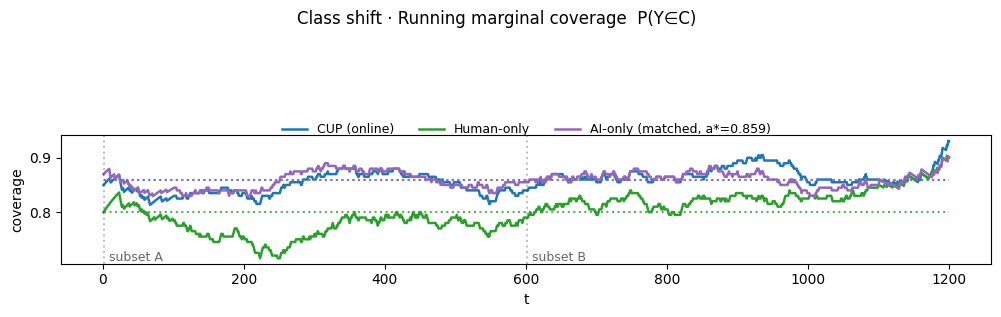

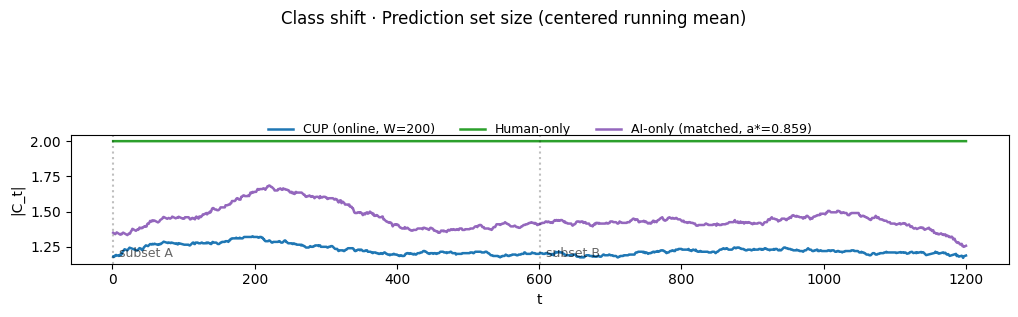

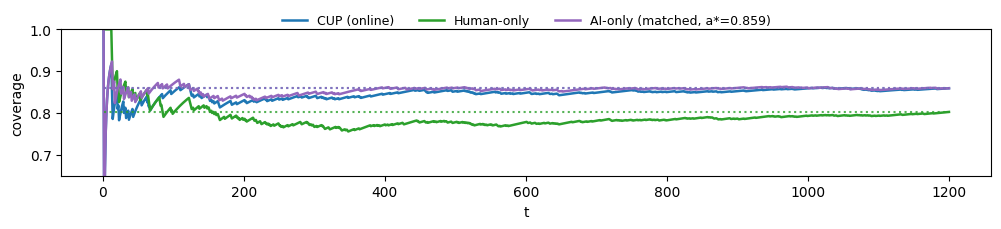

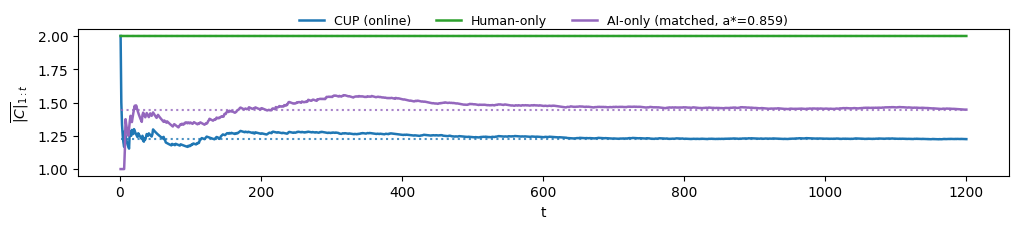

In [8]:
# =======================
# CLASS / LABEL SHIFT
# =======================

subset_A = ["cat","dog","car","truck","boat","bird","bear","bottle"]
subset_B = ["knife","keyboard","elephant","bicycle","airplane","clock","oven","chair"]

class_phases = [
    Phase(name="subset A", steps=None, class_subset=subset_A),
    Phase(name="subset B", steps=None, class_subset=subset_B),
]

cfg_class = RunConfig(
    mode="class",
    model_name="densenet161",
    eps=0.05,
    delta=0.50,
    steps_report=500,
    class_phases=class_phases,
    fixed_noise_level=125,
    fixed_policy={"mode": "topk", "k": 2},
    seed=1337,
    eta=0.005,
    eta_a=0.005,
    eta_b=0.005,
    normalize_levels=True,
)


res_class = compare_online_levels_with_calibration_class(
    cfg_class=cfg_class,
    calib_class_subset=["cat","dog","car","truck"],
    calib_steps=2000,
    W=200,
)

q_inH0_c  = res_class["q_inH0"]
q_notH0_c = res_class["q_notH0"]
events_c  = res_class["events"]

# Windowed marginal coverage & set size
_ = plot_marginal_coverage_hai_vs_baselines(
    cfg_class, adaptive=res_class["adaptive"], W=200, ai_calib_noise=None
)
_ = plot_set_sizes_hai_vs_baselines(
    cfg_class, q_inH0=q_inH0_c, q_notH0=q_notH0_c, W=200, ai_calib_noise=None
)

# running cumulative coverage and size
_ = plot_cum_marginal_coverage_hai_vs_baselines(
    cfg_class, adaptive=res_class["adaptive"], events=events_c
)
_ = plot_cum_set_sizes_hai_vs_baselines(
    cfg_class, q_inH0=q_inH0_c, q_notH0=q_notH0_c, events=events_c
)
